In [60]:
import yfinance as yf
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Download historical data using yfinance
end = datetime.now()
start = datetime(2016, end.month, end.day)
dataset = yf.download('AAPL', start, end)


[*********************100%***********************]  1 of 1 completed


In [61]:
dataset

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-06-28,23.225000,23.415001,23.035000,23.397499,21.604416,161779600
2016-06-29,23.492500,23.637501,23.407499,23.600000,21.791401,146124000
2016-06-30,23.610001,23.942499,23.575001,23.900000,22.068407,143345600
2016-07-01,23.872499,24.117500,23.832500,23.972500,22.135353,104106000
2016-07-05,23.847500,23.850000,23.615000,23.747499,21.927603,110820800
...,...,...,...,...,...,...
2023-06-21,184.899994,185.410004,182.589996,183.960007,183.960007,49515700
2023-06-22,183.740005,187.050003,183.669998,187.000000,187.000000,51245300
2023-06-23,185.550003,187.559998,185.009995,186.679993,186.679993,53079300


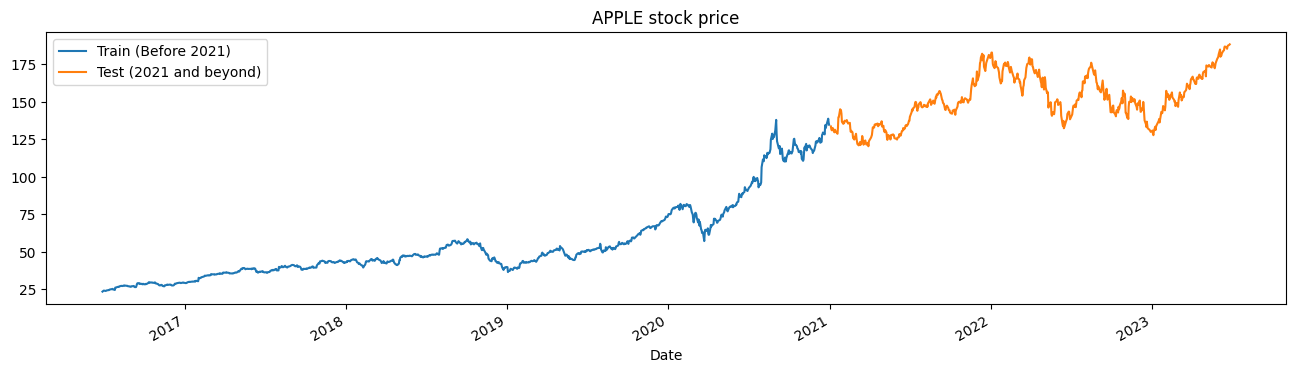

In [62]:
tstart = 2016
tend = 2020


def train_test_plot(dataset, tstart, tend):
    dataset.loc[f"{tstart}":f"{tend}", "High"].plot(figsize=(16, 4), legend=True)
    dataset.loc[f"{tend + 1}":, "High"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {tend + 1})", f"Test ({tend + 1} and beyond)"])
    plt.title("APPLE stock price")
    plt.show()


train_test_plot(dataset, tstart, tend)

In [63]:
def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}", "High"]
    test = dataset.loc[f"{tend + 1}":, "High"]
    return train, test


def train_test_split_values(dataset, tstart, tend):
    train, test = train_test_split(dataset, tstart, tend)
    return train.values, test.values


training_set, test_set = train_test_split_values(dataset, tstart, tend)
training_set

array([ 23.41500092,  23.63750076,  23.94249916, ..., 138.78999329,
       135.99000549, 134.74000549])

In [ ]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

In [ ]:
def split_sequence(sequence, window):
    X = list()
    for i in range(len(sequence)):
        end_ix = i + window
        if end_ix > len(sequence) - 1:
            break
        seq_x = sequence[i:end_ix]
        X.append(seq_x)
    return np.array(X)

window_size = 60
features = 1

X_train = split_sequence(training_set_scaled, window_size)

In [ ]:
train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)

In [ ]:
# Extract the 'Close' prices
series = dataset['Close']

# Fit the ARIMA model
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

# Get the predictions
predictions = model_fit.predict(start=len(train), end=len(series)-1, typ='levels')

In [71]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))

In [68]:
dataset_total = dataset.loc[:, "High"]
inputs = dataset_total[len(dataset_total) - len(test_set) - window_size:].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)

In [ ]:
# Extract the 'Close' prices
series = dataset['Close']

# Split the data into train and test sets
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

# Fit the ARIMA model
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

# Get the predictions
predictions = model_fit.predict(start=len(train), end=len(series)-1, typ='levels')

# # Calculate RMSE
# mse = mean_squared_error(test, predictions)
# rmse = np.sqrt(mse)
# print("RMSE:", rmse)
#
# # Plot the actual values and predictions
# plt.plot(series.index, series, label='Actual')
# plt.plot(predictions.index, predictions, label='Predicted')
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.title('ARIMA Model - Actual vs Predicted')
# plt.legend()
# plt.show()
#

In [ ]:
plot_predictions(test,predictions)

In [70]:
return_rmse(test,predictions)

The root mean squared error is 19.75.


Date
2022-01-31    174.779999
2022-02-01    174.610001
2022-02-02    175.839996
2022-02-03    172.899994
2022-02-04    172.389999
                 ...    
2023-06-21    183.960007
2023-06-22    187.000000
2023-06-23    186.679993
2023-06-26    185.270004
2023-06-27    188.059998
Name: Close, Length: 353, dtype: float64